In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import pandas as pd

# Assuming X_train and X_test are your data

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

In [6]:
# Load your dataset
data_raw = pd.read_csv('merged_pool_data4.csv', index_col='pool_id')

pool_ids = data_raw.index.values
# print(pool_ids)

# This selects all columns except 'Label' as features
X = data_raw.drop('rugpull', axis=1)
drop_cols = ['logindex', 'weth', 'low', 'high', 'close', 'open']
for column in X.columns:
  for drop in drop_cols:
    if drop in column and column in X.columns:
      X = X.drop(column, axis=1)
y = data_raw['rugpull']  # Assuming 'Label' is the column with the rugpull indicator

# Split the dataset into training and testing sets
X_train_raw, X_test_raw, y_train, y_test, pool_ids_train, pool_ids_test = train_test_split(X, y, pool_ids, test_size=0.2, random_state=5)

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler

desired_pool_id = '0x04efaef07927341afb0a5b5a375233cd065c48ec'

# Check if the pool_id is in the training dataset
is_in_training = desired_pool_id in X_train_raw.index

# Check if the pool_id is in the testing dataset
is_in_testing = desired_pool_id in X_test_raw.index

# Print the results
if is_in_training:
    print(f"The pool_id {desired_pool_id} is in the training dataset.")
elif is_in_testing:
    print(f"The pool_id {desired_pool_id} is in the testing dataset.")
else:
    print(f"The pool_id {desired_pool_id} is not in either the training or testing dataset.")

# # # # Separate the data for the excluded pool ID
# X_test_raw = X.loc[[desired_pool_id]]
# y_test = y.loc[[desired_pool_id]]

# # # # Use the rest of the data for training
# X_train_raw = X.drop(desired_pool_id)
# y_train = y.drop(desired_pool_id)

# # # # Ensure that the indices match between X and y in both training and testing sets
# assert X_train_raw.index.equals(y_train.index)
# assert X_test_raw.index.equals(y_test.index)

# Choose the scaler you want to use
scaler = StandardScaler()
# scaler = RobustScaler()

# Replace inf values with NaN
# X_train_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
# X_test_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fit on the training data and transform both training and test data
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed = imputer.transform(X_test_raw)

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert scaled arrays back to DataFrame for compatibility with plotting functions
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

The pool_id 0x04efaef07927341afb0a5b5a375233cd065c48ec is in the testing dataset.


In [9]:
import os

# Define the path for the PDF
pdf_path = 'model_output.pdf'

# Check if the directory exists, if not, create it
if not os.path.exists('content/output/'):
    os.makedirs('content/output/')

pdf_full_path = os.path.join('content/output/', pdf_path)

Training Random Forest...
Evaluating Random Forest...
838 99
Accuracy of Random Forest: 93.28%
              precision    recall  f1-score   support

       False       0.94      0.98      0.96       801
        True       0.87      0.63      0.73       136

    accuracy                           0.93       937
   macro avg       0.90      0.81      0.85       937
weighted avg       0.93      0.93      0.93       937

------------------------------------------------------------
Feature Importances for Random Forest:
Training XGBoost...
Evaluating XGBoost...
824 113
Accuracy of XGBoost: 93.49%
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       801
        True       0.83      0.69      0.76       136

    accuracy                           0.93       937
   macro avg       0.89      0.83      0.86       937
weighted avg       0.93      0.93      0.93       937

------------------------------------------------------------
Feature Impo

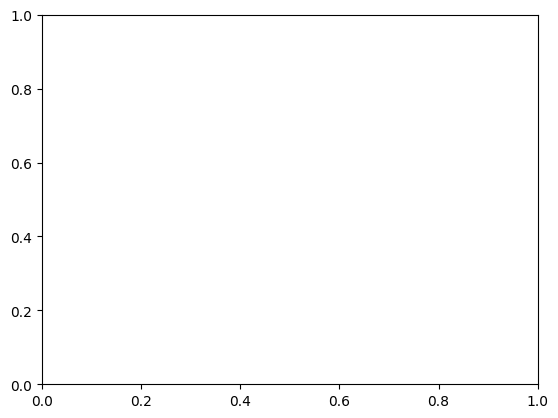

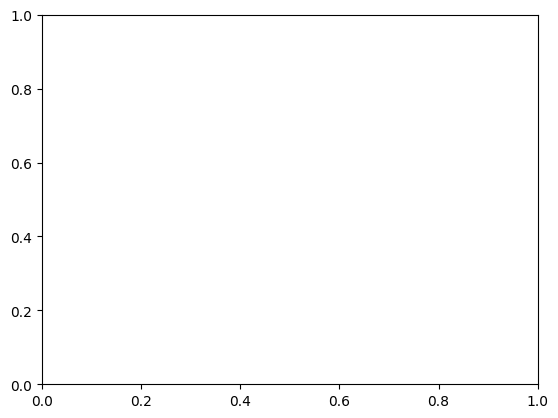

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix


# Define a dictionary with classifiers
classifiers = {
    # "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    # "Support Vector Machine": SVC(kernel='linear'),
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
}

def plot_coefficients(classifier, feature_names, classifier_name):
    if hasattr(classifier, 'coef_'):
        # Get the coefficients
        coefs = classifier.coef_.flatten()
        # Sort the coefficients
        sorted_coefs = np.argsort(coefs)

        # Plot the coefficients
        plt.figure(figsize=(10, 6))
        plt.barh(np.arange(len(coefs)), coefs[sorted_coefs], align='center')
        plt.yticks(np.arange(len(coefs)), feature_names[sorted_coefs])
        plt.xlabel('Coefficient Value')
        plt.title(f'Feature Importance for {classifier_name}')
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')  # Save the figure
        plt.close()  # Close the figure

# Function to plot feature importances
def plot_feature_importances(classifier, X_data, classifier_name):
    # Retrieve feature importances and make sure they're in the same order
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]

    # # Summarize feature importances
    # for f in range(X_data.shape[1]):
    #     print("%d. Feature %s (%f)" % (f + 1, X_data.columns[indices[f]], importances[indices[f]]))

    # Plot feature importances
    plt.figure()
    plt.title(f"Feature Importances in {classifier_name}")
    plt.bar(range(X_data.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_data.shape[1]), X_data.columns[indices], rotation=90)
    plt.xlim([-1, X_data.shape[1]])
    pdf.savefig(bbox_inches='tight')  # Save the figure
    plt.close()  # Close the figure

# Create an empty list to store the results
results = []

# Open a PDF document
with PdfPages(pdf_full_path) as pdf:
    # Iterate over classifiers to train and evaluate them and print feature importances
    for name, clf in classifiers.items():
        fig, ax = plt.subplots()  # Create a figure for the text output

        print(f"Training {name}...")
        clf.fit(X_train, y_train)  # Train the classifier

        print(f"Evaluating {name}...")
        y_pred_prob = clf.predict_proba(X_test)  # Make predictions

        y_pred_prob_class_1 = y_pred_prob[:,1]

        # Set a threshold for classifying as rugpull (e.g., 0.5)
        threshold = 0.5

        # Classify based on the threshold
        y_pred = y_pred_prob_class_1 > threshold

        # Convert X_test.index to a 1-dimensional array
        # pool_ids = X_test.index.values

        # print(X_test)
        # Create a DataFrame with pool ID, probability, and label
        pool_results = pd.DataFrame({
            'Pool ID': pool_ids_test,  # Assuming 'pool_id' is the column with the pool ID
            # 'Pool ID': [desired_pool_id],
            'Probability of Rugpull': y_pred_prob_class_1,
            'Rugpull Label': y_test,
        })

        print(np.array([y_pred == False]).sum(), np.array([y_pred == True]).sum())
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print(f"Accuracy of {name}: %.2f%%" % (accuracy * 100.0))
        print(report)
        print("-" * 60)

        # Write the text output to the PDF
        # Create a figure for the text output
        fig, ax = plt.subplots()
        ax.axis('off')
        text_output = f"Training {name}...\nAccuracy of {name}: {accuracy * 100.0:.2f}%\n\nClassification Report:\n{report}"
        ax.text(0, 1, text_output, va='top', ha='left')
        pdf.savefig(fig, bbox_inches='tight')  # Save the text output figure
        plt.close(fig)

        # Count true positives, true negatives, false positives, and false negatives
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Create a text output for True/False Positive/Negative
        tp_text = f"True Positives (TP): {tp}\n"
        tn_text = f"True Negatives (TN): {tn}\n"
        fp_text = f"False Positives (FP): {fp}\n"
        fn_text = f"False Negatives (FN): {fn}\n"

        # Combine the True/False Positive/Negative information
        tfpn_text = tp_text + tn_text + fp_text + fn_text

        # Write the True/False Positive/Negative information to the PDF
        fig, ax = plt.subplots()
        ax.axis('off')
        tfpn_output = f"True/False Positive/Negative:\n{tfpn_text}"
        ax.text(0, 1, tfpn_output, va='top', ha='left')
        pdf.savefig(fig, bbox_inches='tight')  # Save the text output figure
        plt.close(fig)

        print(f"Feature Importances for {name}:")
        if hasattr(clf, 'feature_importances_'):
            plot_feature_importances(clf, X_train, name)
        elif isinstance(clf, SVC) and clf.kernel == 'linear':
            plot_coefficients(clf, X_train.columns, name)
        elif isinstance(clf, LogisticRegression):
            plot_coefficients(clf, X_train.columns, name)

        # Append the results to the list
        results.append((name, pool_results))

        pool_results.to_csv("content/output/results.csv")

# Print the results for each classifier
# for name, pool_results in results:
#     print(f"Results for {name}:")
#     print(pool_results)
#     print("-" * 60)

# res

In [11]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [12]:
import joblib
# Save the trained model
joblib.dump(model, "xgboost_rugpull.pkl")

# Load the model in your web app
loaded_model = joblib.load("xgboost_rugpull.pkl")


NameError: name 'model' is not defined

In [18]:
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
file_path = "merged_pool_data4.csv"  # Ensure this file is available
data_raw = pd.read_csv(file_path, index_col="pool_id")

# Drop unnecessary columns
drop_cols = ['logindex', 'weth', 'low', 'high', 'close', 'open']
X = data_raw.drop(columns=['rugpull'] + [col for col in data_raw.columns if any(dc in col for dc in drop_cols)])
y = data_raw['rugpull']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
print(X_train.columns)

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate model
y_pred = model.predict(X_test_scaled)
print("Model Evaluation:")
print(classification_report(y_test, y_pred))

# Save model & preprocessing pipeline
'''
joblib.dump(model, "xgboost_rugpull.pkl")
joblib.dump(imputer, "imputer.pkl")
joblib.dump(scaler, "scaler.pkl")

print("✅ Model training complete. Saved model and preprocessor.")
'''


Index(['avg_daily_volume_change_per_swap', 'mean_feesusd', 'mean_tick',
       'mean_otherTokenprice', 'mean_totalvaluelockedusd', 'mean_txcount',
       'mean_volumeotherToken', 'mean_volumeusd', 'variance_feesusd',
       'variance_tick', 'variance_otherTokenprice',
       'variance_totalvaluelockedusd', 'variance_txcount',
       'variance_volumeotherToken', 'variance_volumeusd', 'mean_otherToken_x',
       'mean_amountusd_x', 'mean_tickupper_x', 'variance_otherToken_x',
       'variance_amountusd_x', 'variance_tickupper_x', 'mean_otherToken_y',
       'mean_amountusd_y', 'mean_tickupper_y', 'variance_otherToken_y',
       'variance_amountusd_y', 'variance_tickupper_y',
       'top_owner_1_distribution', 'top_owner_2_distribution',
       'top_owner_3_distribution', 'top_owner_4_distribution',
       'top_owner_5_distribution', 'top_owner_6_distribution',
       'top_owner_7_distribution', 'top_owner_8_distribution',
       'top_owner_9_distribution', 'top_owner_10_distribution'],
 

'\njoblib.dump(model, "xgboost_rugpull.pkl")\njoblib.dump(imputer, "imputer.pkl")\njoblib.dump(scaler, "scaler.pkl")\n\nprint("✅ Model training complete. Saved model and preprocessor.")\n'